# Visualise FFT sentiment embeddings in 2D

### Imports

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import os
os.chdir('..')
from spreadsheet_data_handling import tweak_raw_df

### Split consistent with previous notebooks

Save out the sample data

In [2]:
from sklearn.model_selection import train_test_split

raw_df = pd.read_csv('../pxtextmining/datasets/v6framework_230831.csv').dropna(subset='Comment sentiment')

trnval_df, test_df = train_test_split(
    raw_df, test_size=0.15,
    random_state=0,
    stratify=raw_df['Comment sentiment']
)

fft_df_trn, fft_df_val = train_test_split(
    trnval_df, test_size=1/4, random_state=0,
    stratify=trnval_df['Comment sentiment']
)

#For viz, use val + test splits
fft_df_valtest = pd.concat([fft_df_val, test_df], axis=0)
fft_df_valtest

fft_df_valtest[[
    'Comment ID', 'Trust', 'Respondent ID', 'Date', 'Service type 1',
    'Service type 2', 'FFT categorical answer', 'FFT question', 'FFT answer',
]].to_csv('data/_example_data_valtest.csv')

del raw_df, fft_df_trn, fft_df_val, fft_df_valtest

### Load local model and tokenizer

In [5]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

#Load tokenizer + model locally
tokenizer = AutoTokenizer.from_pretrained('data/hfcheckpoint-tokenizer')
model = AutoModelForSequenceClassification.from_pretrained('data/hfcheckpoint-tinybert-sst5-fft')
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

### FFT to dataset

In [6]:
from model_utils import combine_question_answer
from datasets import Dataset

df = (
    pd.read_csv('data/_example_data_valtest.csv', index_col=0)
    .pipe(tweak_raw_df)
    [['question_type', 'answer_clean']]
)
display(df)

fft_dataset = Dataset.from_pandas(df).remove_columns(['__index_level_0__'])

fft_dataset = fft_dataset\
    .map(combine_question_answer, batched=True)\
    .remove_columns(['question_type', 'answer_clean',])

fft_dataset.shuffle()[:1]

,question_type,answer_clean
298,nonspecific,"Everything that was done, I could ask for no b..."
7799,could_improve,When I arrived at the hospital following my ca...
4273,could_improve,Nothing
877,nonspecific,"Crew were excellent, response time not so much."
3654,could_improve,Because everything was very good.
...,...,...
4301,nonspecific,On a couple of occasions I was advised by the ...
6880,could_improve,Caring for someone as an individual - less as ...
3905,could_improve,Nothing they weee brill
2652,what_good,NO.


Map:   0%|          | 0/2236 [00:00<?, ? examples/s]

{'q_and_a': ['Question: What could be improved? Answer: In current climate nothing could be done any better.']}

### Get embeddings

In [7]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from scipy.special import softmax

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_num_threads(4); device = 'cpu' #mimic 4-core machine

dynamic_padding_collator = DataCollatorWithPadding(tokenizer)

#Tokenize dataset
fft_tokenized = fft_dataset\
    .map(lambda batch: tokenizer(batch['q_and_a'], truncation=True, max_length=512), batched=True)\
    .remove_columns('q_and_a')

loader = DataLoader(
    fft_tokenized, batch_size=32,
    pin_memory=False if device == 'cpu' else True,
    shuffle=False, collate_fn=dynamic_padding_collator
)

#Embeddings
embeddings = []
model.to(device)
model.eval()
with torch.no_grad():
    for minibatch in loader:
        minibatch = {k: v.to(device) for k, v in minibatch.items()}

        # outputs = model.distilbert(input_ids=minibatch['input_ids'], attention_mask=minibatch['attention_mask'])
        outputs = model.bert(input_ids=minibatch['input_ids'], attention_mask=minibatch['attention_mask'])
        
        # outputs = outputs.last_hidden_state.cpu().numpy().mean(axis=1) #[B, L, emb] -> avg over L -> [B, emb]
        outputs = outputs.pooler_output.cpu().numpy() #[B, L, emb] -> final CLS rep -> [B, emb]

        embeddings.append(outputs)

embeddings = np.concatenate(embeddings, axis=0)

#Predictions
predictions = []
entropies = []
class_probs = []

model.eval()
with torch.no_grad():
    for minibatch in loader:
        minibatch = {k: v.to(device) for k, v in minibatch.items()}
        logits = model(**minibatch).logits.cpu().numpy()
        probas = softmax(logits, axis=1)

        preds = logits.argmax(axis=1)
        entr = -(probas * np.log2(probas)).sum(axis=1)
        class_p = probas[np.arange(len(logits)), preds]

        predictions.append(preds)
        entropies.append(entr)
        class_probs.append(class_p)
predictions = np.concatenate(predictions)
entropies = np.concatenate(entropies) / np.log2(5) * 100
class_probs = np.concatenate(class_probs)

Map:   0%|          | 0/2236 [00:00<?, ? examples/s]

### Interactive visualisation

In [8]:
%matplotlib widget

from umap import UMAP

from ipywidgets import interact, HTML
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import textwrap

interactive(children=(IntSlider(value=10, description='s', max=20, min=1), FloatSlider(value=0.5, description=…

HTML(value='')

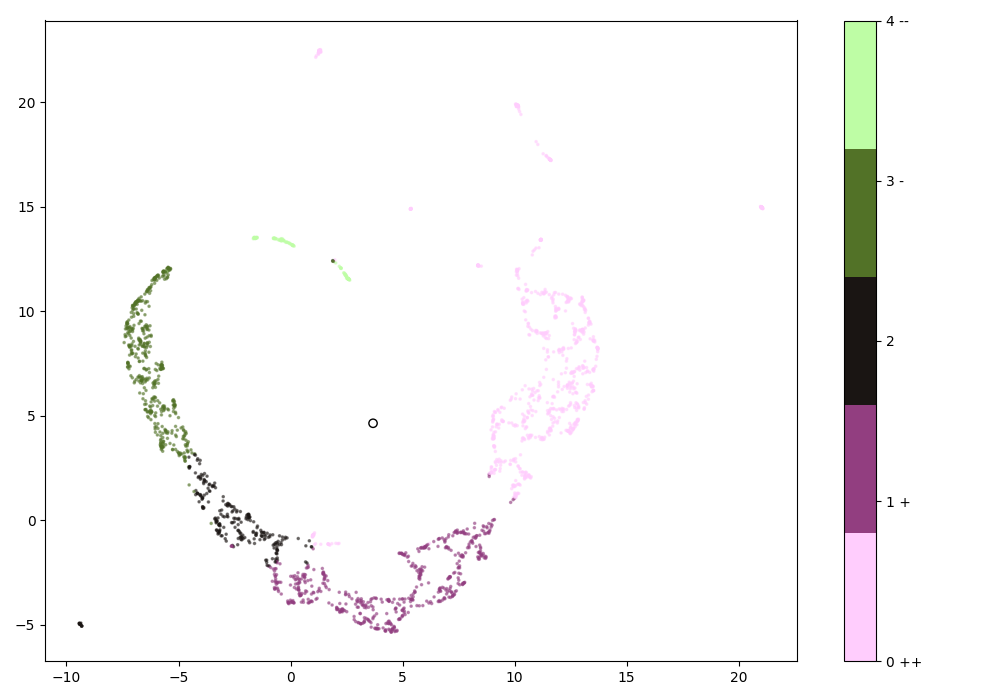

In [9]:
#Get 2D projections
proj = UMAP(n_neighbors=15, densmap=False, random_state=None).fit_transform(embeddings)
proj_x, proj_y = proj.T

#Define colourmap
cmap = ListedColormap(['tab:green', 'tab:orange', 'tab:red'])
cmap = plt.get_cmap('vanimo', 5)

#Plot figure
plt.close('all')
fig = plt.figure(figsize=(10, 7), clear=True, num=0)
scatter = plt.scatter(*proj.T, marker='.', s=10, c=predictions, cmap=cmap)
cbar = plt.colorbar()
cbar.ax.set_yticks([0, 1, 2, 3, 4]); cbar.ax.set_yticklabels(['0 ++', '1 +', '2', '3 -', '4 --'])

plt.tight_layout()


#
#ipywidgets slider
#
def size_alpha_adjust(s, alpha):
    scatter.set_alpha(alpha)
    scatter.set_sizes([s])

slider = interact(size_alpha_adjust, s=(1, 20, 1), alpha=(0.1, 1, 0.1))


#
#ipywidgets live html table
#
live_html = HTML()

def update_live_table(event):
    if not event.inaxes:
        return
    xy = np.array([[event.xdata, event.ydata]])
    closest_index = np.argmin(np.linalg.norm(proj - xy, axis=1))
    live_html.value = df.iloc[closest_index].to_frame().to_html()
display(live_html)

fig.canvas.mpl_connect('motion_notify_event', update_live_table)


#
# Tracker
#
tracker = plt.gca().scatter(*proj.mean(axis=0), c='none', edgecolor='black')
def mouse_move_callback(event):
    ax = plt.gca()

    #if not event.inaxes
    if event.inaxes != ax:
        return
    
    xy = np.array([event.xdata, event.ydata])
    closest_ix = np.argmin(np.linalg.norm(proj - xy.reshape(1, 2), axis=1), axis=0)

    txt = textwrap.fill(df.iloc[closest_ix].answer_clean, width=150)
    txt = df.iloc[closest_ix].answer_clean[:150]
    ax.set_title(txt, fontsize=9, weight='bold')
    tracker.set_offsets(proj[closest_ix])

    ax.figure.tight_layout()

fig.canvas.mpl_connect('motion_notify_event', mouse_move_callback);

### View data from a particular region

In [8]:
df.loc[(proj[:, 0] < 8.5) & (proj[:, 1] > 5)]

,question_type,answer_clean
1,nonspecific,Very professional crew dealt with me promptly ...
2,what_good,For the first time I felt I was really listene...
3,could_improve,Quick straight forward help and answer and exp...
5,nonspecific,Thay we're very attentive and quick to respond
8,could_improve,"Yes, I have to say your Patient Transport Crew..."
...,...,...
2225,could_improve,Keep doing a great job
2227,nonspecific,Prompt and efficient Very friendly Put you at ...
2228,nonspecific,The paramedics who came following my TIA were ...
2232,could_improve,Because it was very good.
